# Import bibliotek

In [33]:
import json
import string
import morfeusz2
import numpy as np
import pandas as pd
import operator as op
import itertools as it
from wordcloud import WordCloud
from matplotlib import pyplot as plt
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from nltk.corpus import PlaintextCorpusReader
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Korpus dokumentów

In [34]:
corpus_dir = ("./my_original_summaries")
corpus = PlaintextCorpusReader(corpus_dir, ".*\.txt")
file_names = corpus.fileids()
file_names

['Cyberbezpieczenstwo.txt',
 'Ekonomia_Cyfrowa.txt',
 'Energia_Odnawialna.txt',
 'Historia_Polski.txt',
 'Kosmos_i_Eksploracja.txt',
 'Ladowanie_na_Ksiezycu.txt',
 'Migracje_Ludnosci.txt',
 'Ochrona_Srodowiska.txt',
 'Pandemia_COVID19.txt',
 'Praca_Zdalna.txt',
 'Przemiany_Kulturowe.txt',
 'Przemysl_4_0.txt',
 'Przyszlosc_Edukacji.txt',
 'Rewolucja_Internetu.txt',
 'Rozwoj_Miast.txt',
 'Starzenie_Spoleczenstw.txt',
 'Sztuczna_Inteligencja.txt',
 'Transport_Publiczny.txt',
 'Zmiany_Klimatu.txt',
 'Zrownowazony_Rozwoj.txt']

# Wstępne przygotowanie dokumentów

In [35]:
documents = {}
for file in file_names:
    documents[file] = corpus.raw(file)
print(json.dumps(documents, indent = 4, ensure_ascii = False)) 

{
    "Cyberbezpieczenstwo.txt": "Cyberbezpieczeństwo to ochrona systemów komputerowych i sieci przed atakami, kradzieżą danych i innymi zagrożeniami. Wraz z rozwojem technologii rośnie liczba cyberataków na firmy i osoby prywatne. Skuteczna ochrona wymaga stosowania nowoczesnych narzędzi, edukacji użytkowników i ciągłego monitorowania zagrożeń. Cyberbezpieczeństwo jest kluczowe dla funkcjonowania państw, firm i instytucji.",
    "Ekonomia_Cyfrowa.txt": "Ekonomia cyfrowa opiera się na wykorzystaniu technologii informatycznych w gospodarce. Rozwój internetu, e-commerce i usług online zmienia sposób prowadzenia biznesu. Firmy inwestują w cyfrowe narzędzia, aby zwiększyć konkurencyjność i dotrzeć do nowych klientów. Ekonomia cyfrowa stwarza nowe możliwości, ale także wyzwania związane z bezpieczeństwem i ochroną danych.",
    "Energia_Odnawialna.txt": "Energia odnawialna pochodzi ze źródeł naturalnych, które odnawiają się w krótkim czasie. Do najważniejszych należą energia słoneczna, wiat

In [36]:
stoplist_file = open("./my_stopwords_pl.txt", "r", encoding="UTF-8")
stoplist = stoplist_file.read().splitlines()
stoplist_file.close()
stoplist = stoplist[4:]
stoplist

['ach',
 'acz',
 'aczkolwiek',
 'aj',
 'albo',
 'ale',
 'ależ',
 'ani',
 'aż',
 'bardziej',
 'bardzo',
 'bo',
 'bowiem',
 'by',
 'byli',
 'bynajmniej',
 'być',
 'był',
 'była',
 'było',
 'były',
 'będzie',
 'będą',
 'cali',
 'cała',
 'cały',
 'ci',
 'cię',
 'ciebie',
 'co',
 'cokolwiek',
 'coś',
 'czasami',
 'czasem',
 'czemu',
 'czy',
 'czyli',
 'daleko',
 'dla',
 'dlaczego',
 'dlatego',
 'do',
 'dobrze',
 'dokąd',
 'dość',
 'dużo',
 'dwa',
 'dwaj',
 'dwie',
 'dwoje',
 'dziś',
 'dzisiaj',
 'gdy',
 'gdyby',
 'gdyż',
 'gdzie',
 'gdziekolwiek',
 'gdzieś',
 'go',
 'i',
 'ich',
 'ile',
 'im',
 'inna',
 'inne',
 'inny',
 'innych',
 'iz',
 'ja',
 'jak',
 'jaka',
 'jakby',
 'jaki',
 'jakichś',
 'jakie',
 'jakiś',
 'jakiż',
 'jakkolwiek',
 'jako',
 'jakoś',
 'je',
 'jeden',
 'jedna',
 'jedno',
 'jednak',
 'jednakże',
 'jego',
 'jej',
 'jemu',
 'jest',
 'jestem',
 'jeszcze',
 'jeśli',
 'jeżeli',
 'już',
 'każdy',
 'kiedy',
 'kilka',
 'kimś',
 'kto',
 'ktokolwiek',
 'ktoś',
 'która',
 'które',
 

In [37]:
def lemmatize(text):
    morf = morfeusz2.Morfeusz()
    segments = it.groupby(morf.analyse(text), op.itemgetter(0,1))
    def disambiguate(group):
        pairs = ((len(descr), lemma) for _, _, (_, lemma, descr, _, _, ) in group)
        perpl, lemma = min(pairs)
        return lemma.split(":")[0]
    lemmas = (disambiguate(group) for key, group in segments)
    return " ".join(filter(str.isalpha, lemmas))

In [38]:
for key in documents:
    documents[key] = documents[key].lower()
    documents[key] = "".join([char for char in documents[key] if char not in string.punctuation])
    documents[key] = lemmatize(documents[key])
    documents[key] = " ".join([word for word in word_tokenize(documents[key], language="polish") if word not in stoplist])
print(json.dumps(documents, indent=4, ensure_ascii=False))  

{
    "Cyberbezpieczenstwo.txt": "cyberbezpieczeństwo to ochrona system komputerowy sieć przed atak kradzież dana zagrożenie wraz z rozwój technologia rośnie liczba cyberatak na firma osoba prywatny skuteczny ochrona wymagać stosować nowoczesny narzędzie edukacja użytkownik ciągły monitorować zagrożenie cyberbezpieczeństwo kluczowy funkcjonowanie państwo firma instytucja",
    "Ekonomia_Cyfrowa.txt": "ekonomia cyfrowy opierać się na wykorzystanie technologia informatyczny w gospodarka rozwój internet ecommerce usługa online zmieniać sposób prowadzenie biznes firma inwestować w cyfrowy narzędzie zwiększyć konkurencyjność dotrzeć nowa klient ekonomia cyfrowy stwarzać nowy możliwość także wyzwanie związany z bezpieczeństwo ochrona dana",
    "Energia_Odnawialna.txt": "energia odnawialny pochodzić z źródło naturalny odnawiać się w krótki czas ważny należeć energia słoneczny wiatrowy wodny geotermalny rozwój technologia pozwalać na coraz szeroki wykorzystać ten źródło w produkcja energia el

# Utworzenie macierzy częstości 

In [39]:
docs = pd.DataFrame.from_dict(documents, orient = 'index')
docs.columns = ['content']
docs

,content
Cyberbezpieczenstwo.txt,cyberbezpieczeństwo to ochrona system komputer...
Ekonomia_Cyfrowa.txt,ekonomia cyfrowy opierać się na wykorzystanie ...
Energia_Odnawialna.txt,energia odnawialny pochodzić z źródło naturaln...
Historia_Polski.txt,historia polski bogaty pełny przełomowy wydarz...
Kosmos_i_Eksploracja.txt,eksploracja kosmos to z duży osiągnięcie ludzk...
Ladowanie_na_Ksiezycu.txt,pierwszy lądowanie człowiek na księżyc w rok p...
Migracje_Ludnosci.txt,migracja ludność to przemieszczać się człowiek...
Ochrona_Srodowiska.txt,ochrona środowisko to działanie maić na cel za...
Pandemia_COVID19.txt,pandemia wybuchnąć pod koniec rok szybko rozpr...
Praca_Zdalna.txt,praca zdalny stała się popularny dzięki rozwój...


In [40]:
count_vectorizer = CountVectorizer()
counts_tf = count_vectorizer.fit_transform(docs['content'])
counts_tf.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(20, 550))

In [41]:
tfidf_vectorizer = TfidfVectorizer()
counts_tfidf = tfidf_vectorizer.fit_transform(docs['content'])
counts_tfidf.toarray()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.10762236,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], shape=(20, 550))

# Chmury tagów

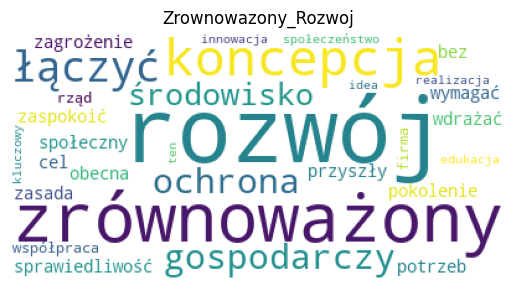

In [42]:
wordcloud = WordCloud(background_color = "white", max_words = 5000, contour_width = 3, contour_color = "steelblue")
for index, row in docs.iterrows():
    wordcloud.generate(row['content'])
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(index.replace(".txt", ""))
    plt.savefig("./wordclouds/{}".format(index.replace(".txt", ".png")))

# Topic modelling

In [43]:
def plot_top_words(model, feature_names, n_top_words, title, subplots):
    fig, axes = plt.subplots(*subplots, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[-n_top_words:]
        top_features = feature_names[top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx + 1}", fontdict={"fontsize": 30})
        ax.tick_params(axis = "both", which = "major", labelsize = 20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize = 40)

    plt.subplots_adjust(top = 0.90, bottom = 0.05, wspace = 0.90, hspace = 0.3)
    plt.savefig(f"./my_topics/{title}.png")

In [44]:
n_components = 3
feature_names = count_vectorizer.get_feature_names_out()
n_top_features = 20
size = [1, 3]

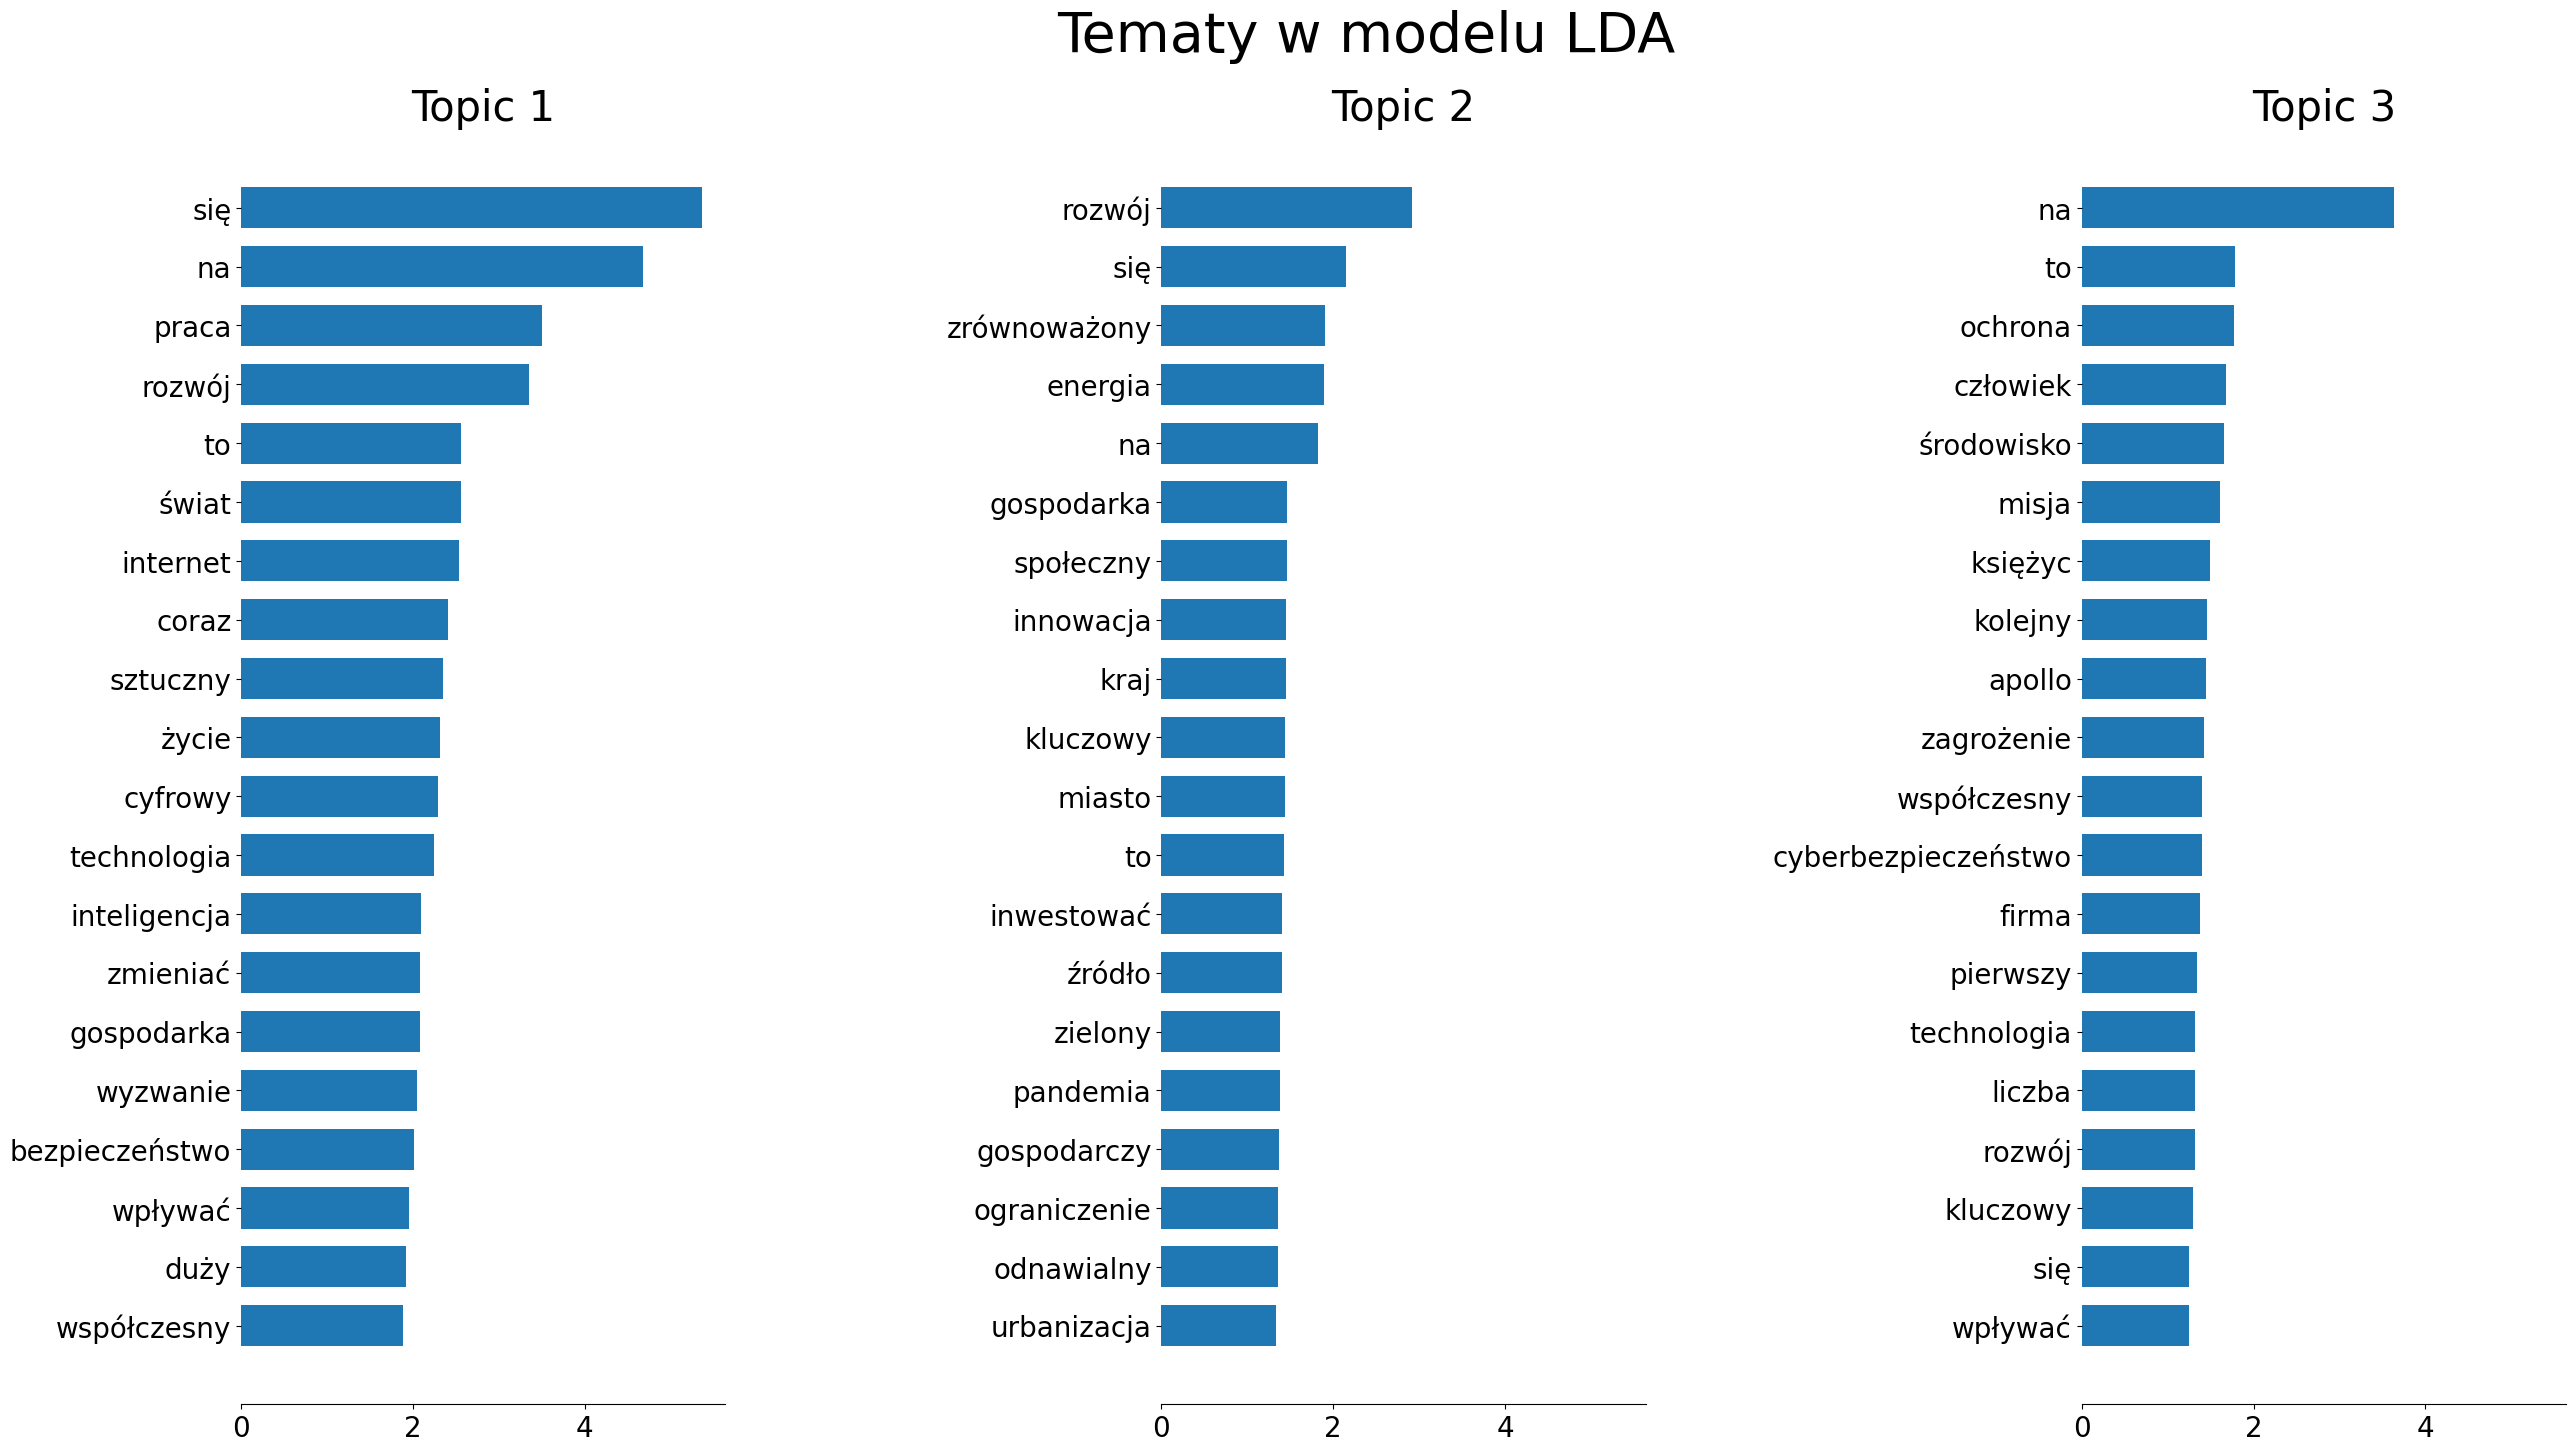

In [45]:
lda = LatentDirichletAllocation(
    n_components = n_components, 
    max_iter = 5, 
    learning_method = 'online', 
    learning_offset = 50,
    random_state = 0
)
lda.fit(counts_tf)
plot_top_words(lda, feature_names, n_top_features, "Tematy w modelu LDA", size)

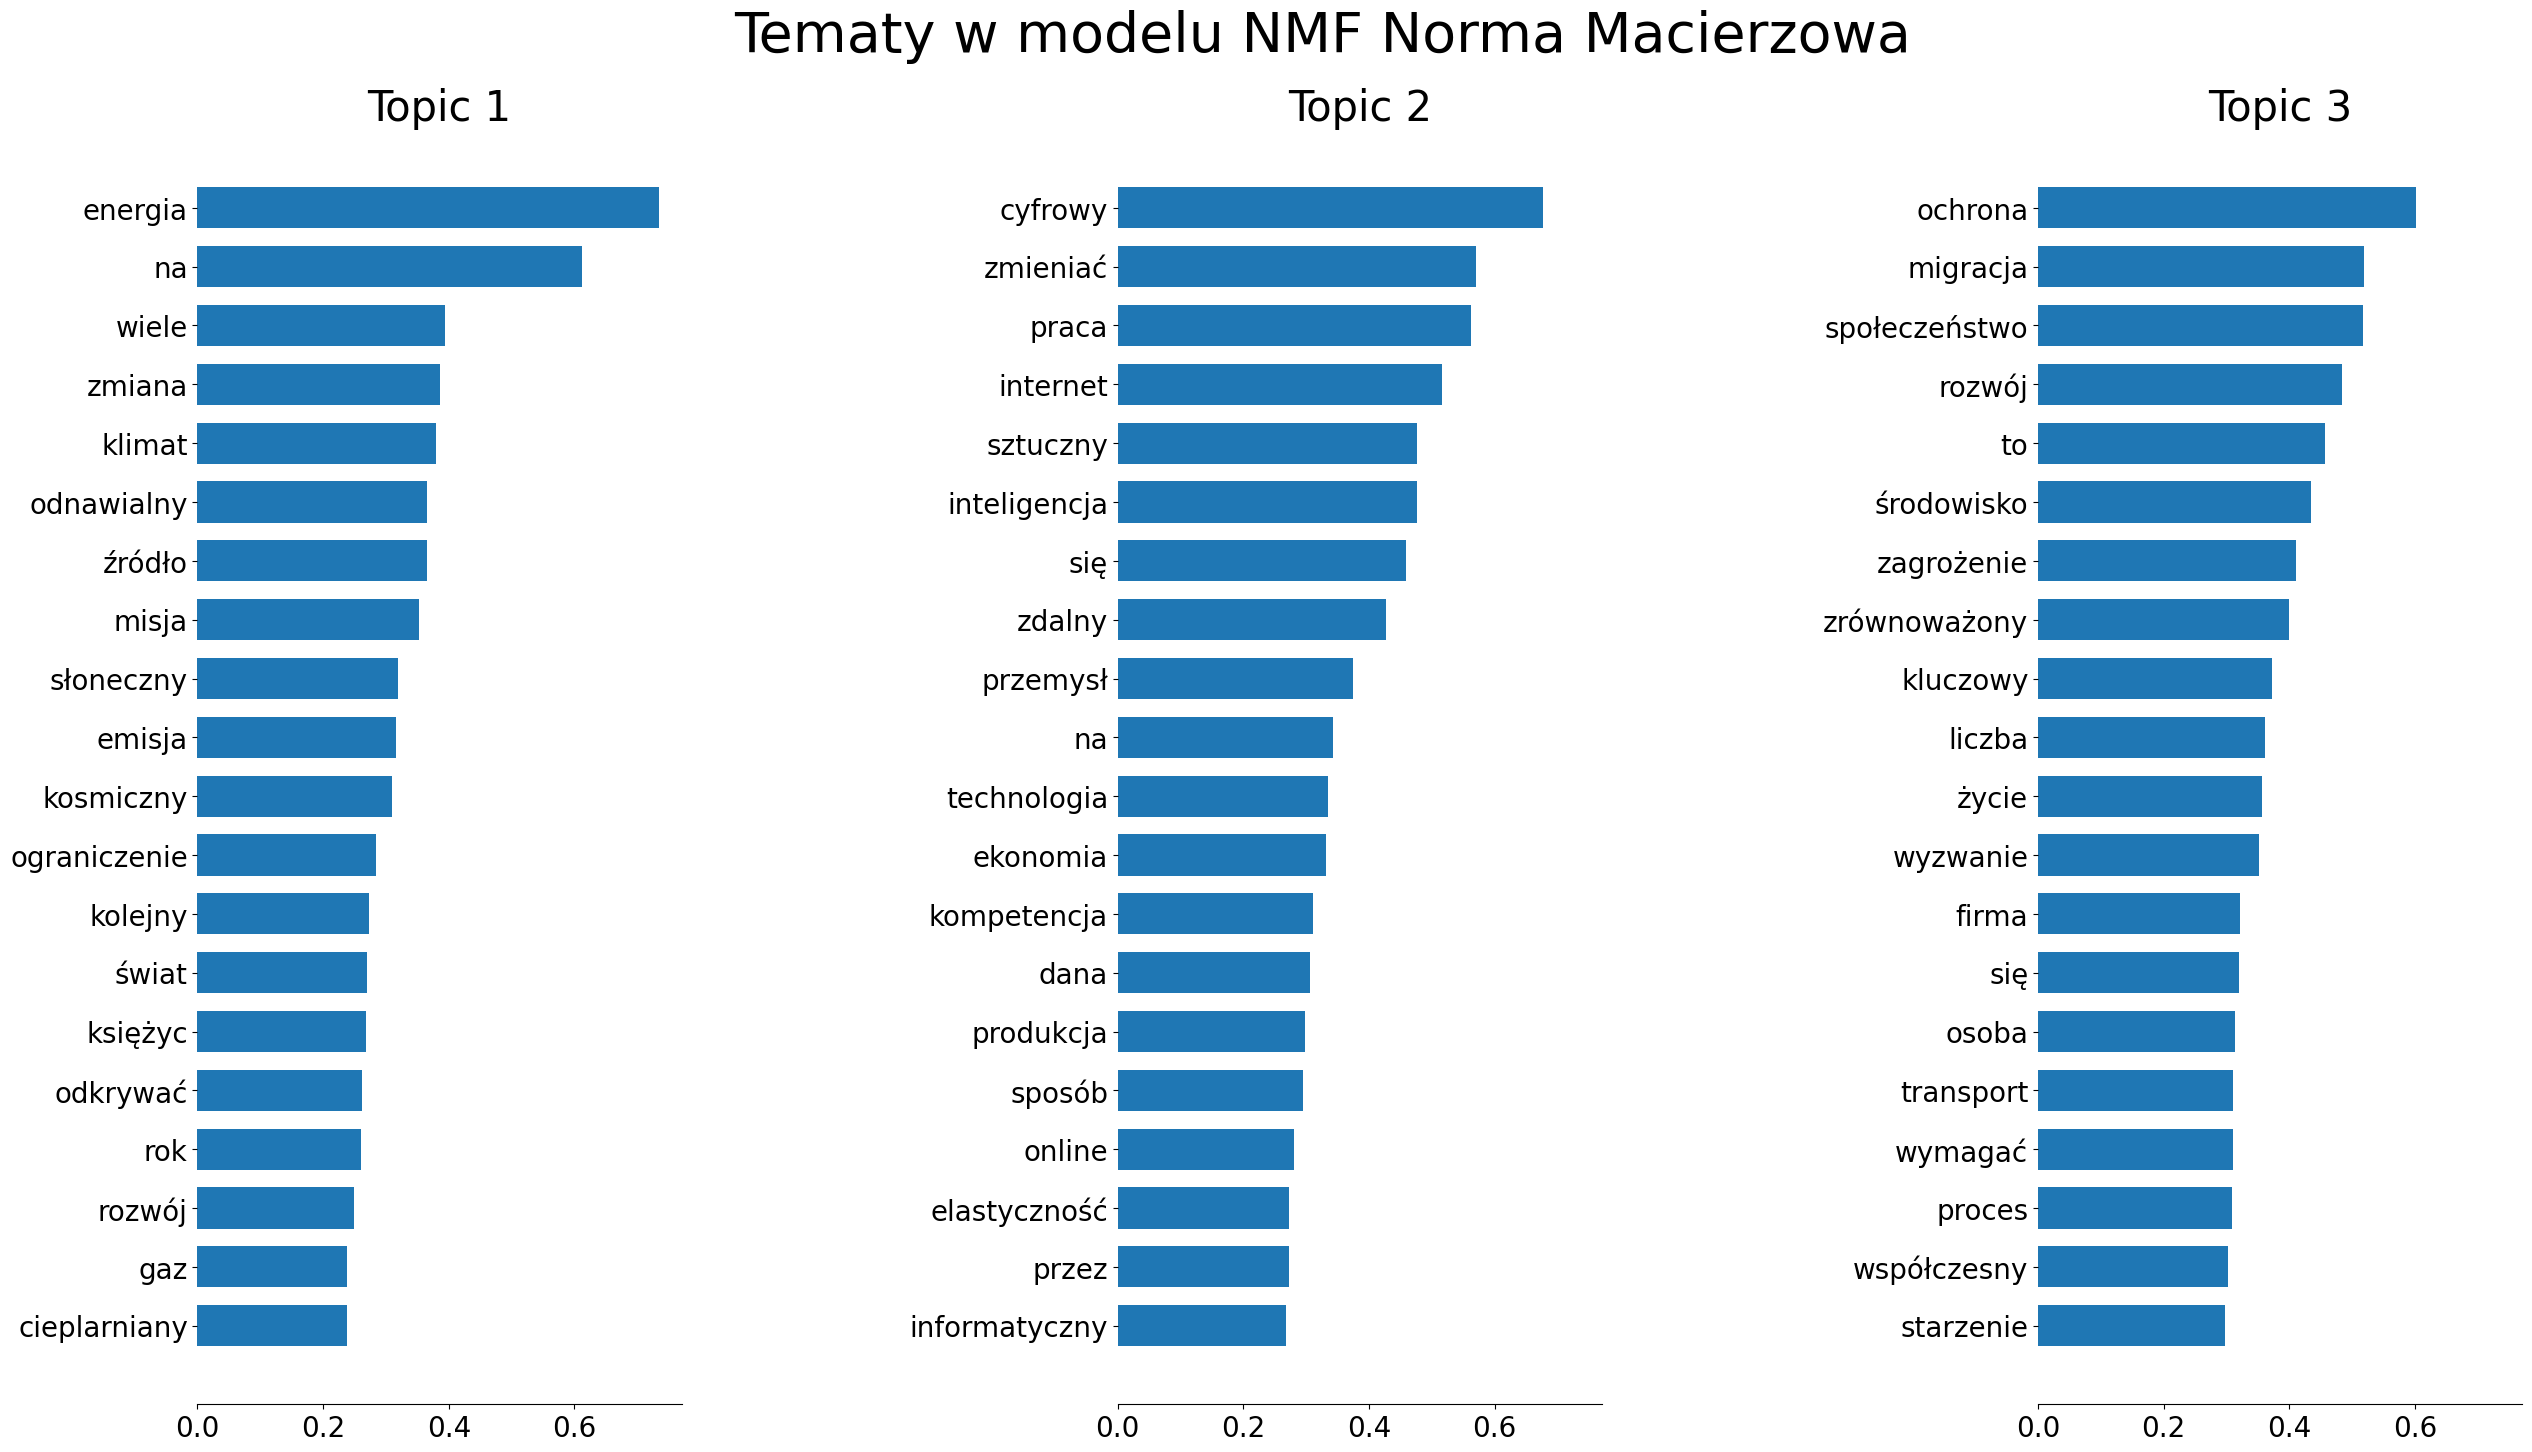

In [46]:
nmf_fm = NMF(
    n_components=n_components,
    random_state = 1, 
    alpha_H = .00005,
    alpha_W = .00005,
    l1_ratio = .5
)
nmf_fm.fit(counts_tfidf)
plot_top_words(nmf_fm, feature_names, n_top_features, "Tematy w modelu NMF Norma Macierzowa", size)

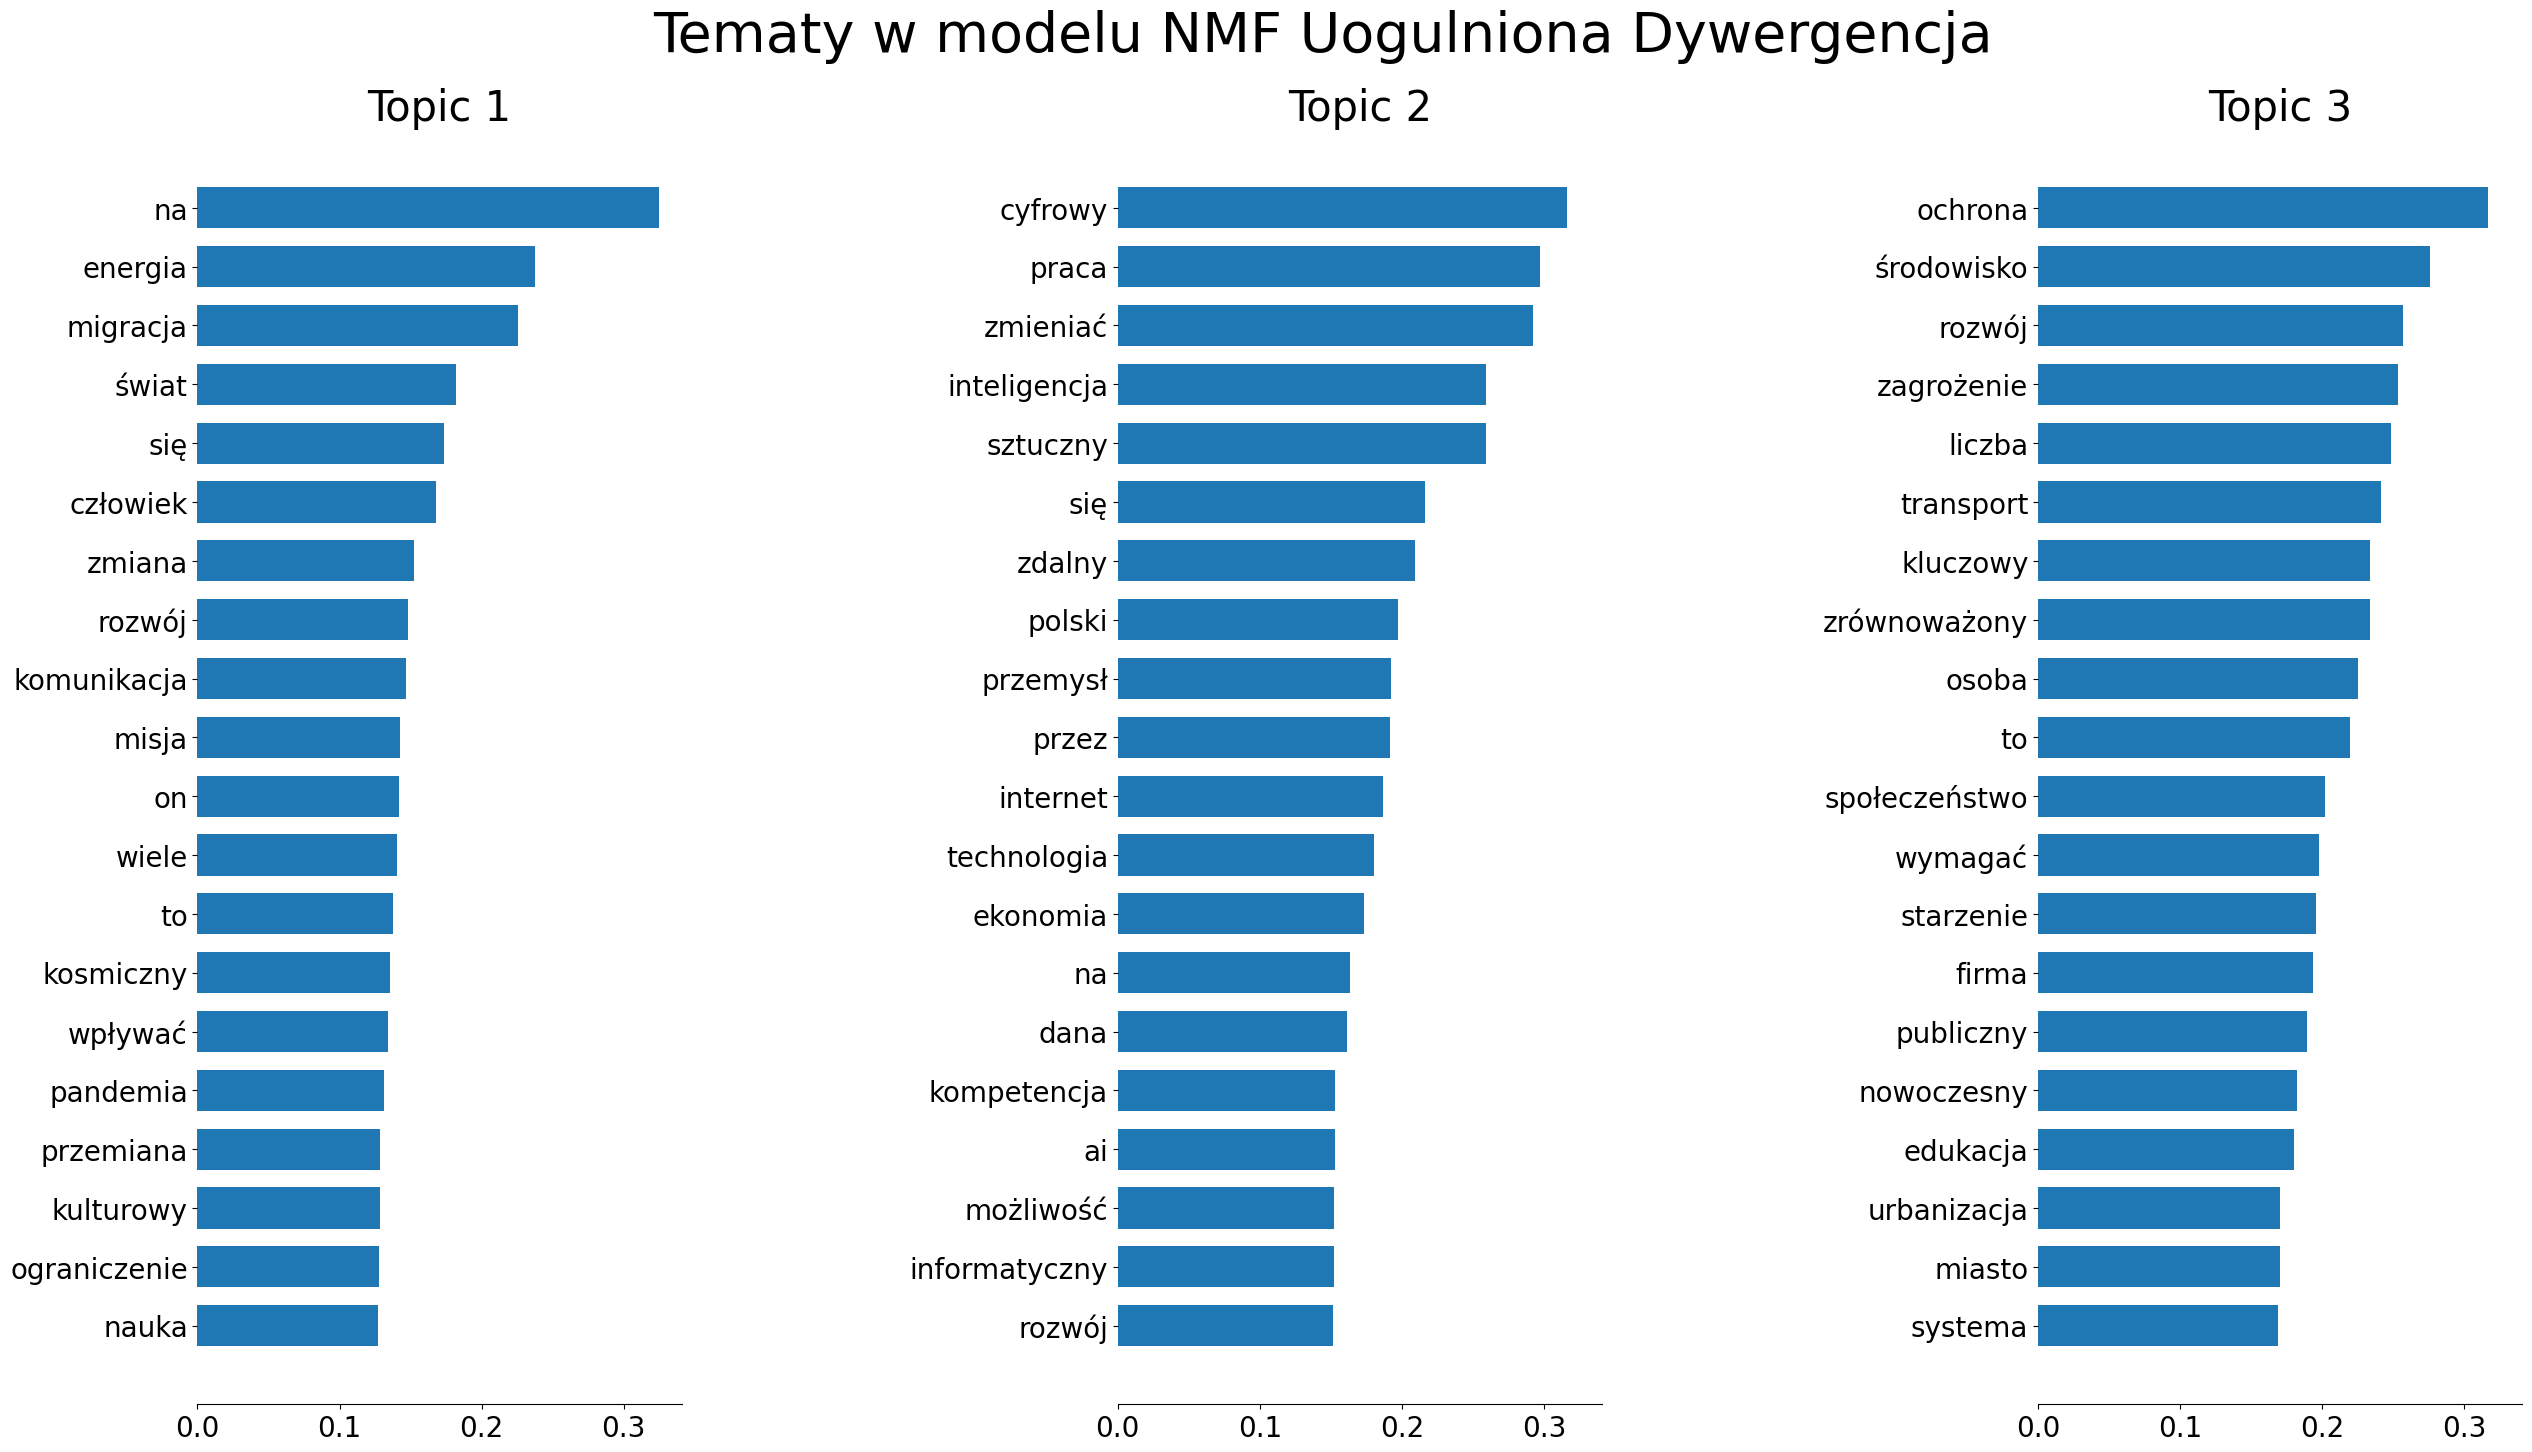

In [47]:
nmf_kl = NMF(
    n_components = n_components,
    random_state = 1, 
    beta_loss = 'kullback-leibler',
    solver = 'mu',
    max_iter = 1000,
    alpha_H = .00005,
    alpha_W = .00005,
    l1_ratio = .5
)
nmf_kl.fit(counts_tfidf)
plot_top_words(nmf_kl, feature_names, n_top_features, "Tematy w modelu NMF Uogulniona Dywergencja", size)

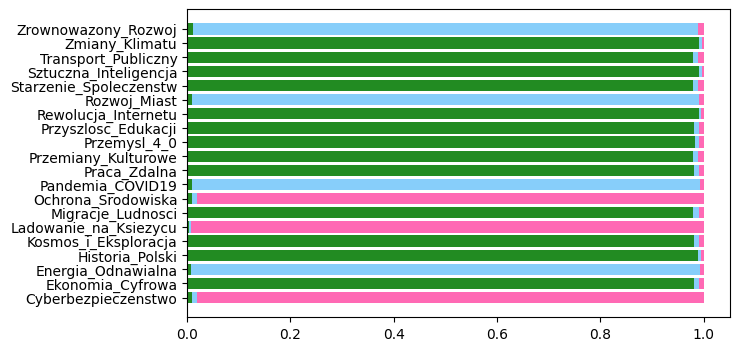

In [48]:
docs_topics = pd.DataFrame(lda.transform(counts_tf), columns=['Topic 1', 'Topic 2', 'Topic 3'])
docs_topics.index = [file_name.replace(".txt", "") for file_name in file_names]
plt.figure(figsize=(7, 4))
colors = ['forestgreen', 'lightskyblue', 'hotpink']
left = [0] * len(docs_topics)
for i, col in enumerate(docs_topics.columns):
    plt.barh(docs_topics.index, docs_topics[col], left = left, label = col, color = colors[i])
    left=[left[j] + docs_topics[col].iloc[j] for j in range(len(docs_topics))]

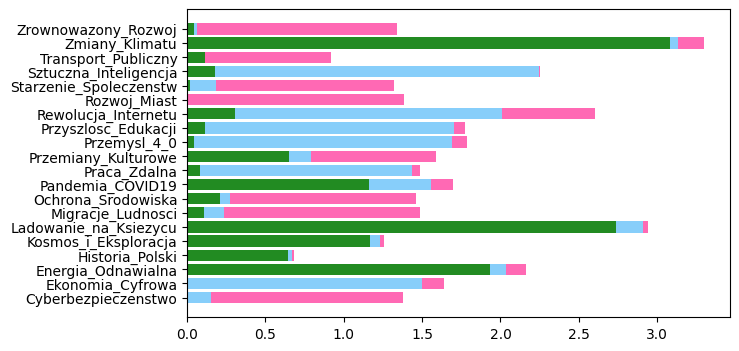

In [49]:
docs_topics = pd.DataFrame(nmf_fm.transform(counts_tf), columns=['Topic 1', 'Topic 2', 'Topic 3'])
docs_topics.index = [file_name.replace(".txt", "") for file_name in file_names]
plt.figure(figsize = (7, 4))
colors = ['forestgreen', 'lightskyblue', 'hotpink']
left = [0] * len(docs_topics)
for i, col in enumerate(docs_topics.columns):
    plt.barh(docs_topics.index, docs_topics[col], left = left, label = col, color = colors[i])
    left=[left[j] + docs_topics[col].iloc[j] for j in range(len(docs_topics))]

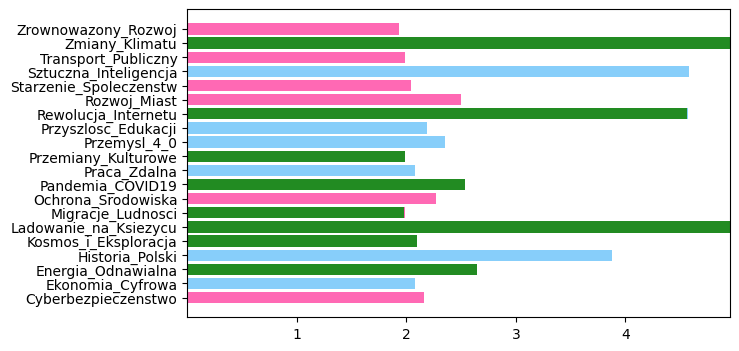

In [50]:
docs_topics = pd.DataFrame(nmf_kl.transform(counts_tf), columns=['Topic 1', 'Topic 2', 'Topic 3'])
docs_topics.index = [file_name.replace(".txt", "") for file_name in file_names]
plt.figure(figsize = (7, 4))
colors = ['forestgreen', 'lightskyblue', 'hotpink']
left = [0] * len(docs_topics)
for i, col in enumerate(docs_topics.columns):
    plt.barh(docs_topics.index, docs_topics[col], left = left, label = col, color = colors[i])
    left=[left[j] + docs_topics[col].iloc[j] for j in range(len(docs_topics))]

# Analiza skupień

In [51]:
def plot_dendrogram(model, **kwargs):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)
    dendrogram(linkage_matrix, **kwargs)

In [52]:
n_docs = len(file_names)
cs = cosine_similarity(counts_tfidf, counts_tfidf).flatten().reshape(n_docs, n_docs)
cs

array([[1.        , 0.11492136, 0.02237541, 0.02148764, 0.01984899,
        0.02676854, 0.0741285 , 0.10790454, 0.02615763, 0.06243406,
        0.03201274, 0.06974892, 0.05583416, 0.11310326, 0.04903355,
        0.06489261, 0.0219042 , 0.0805214 , 0.03255662, 0.19064915],
       [0.11492136, 1.        , 0.05456771, 0.00222994, 0.03402118,
        0.02331452, 0.09584097, 0.06307591, 0.04360916, 0.10613544,
        0.06295223, 0.17478046, 0.13315963, 0.19252799, 0.04765239,
        0.0593671 , 0.05867833, 0.00879956, 0.03956678, 0.04955952],
       [0.02237541, 0.05456771, 1.        , 0.02070277, 0.03719115,
        0.02638163, 0.03196002, 0.06668268, 0.05238645, 0.07569776,
        0.05807705, 0.0646265 , 0.05321796, 0.03412689, 0.06229044,
        0.01098162, 0.0381071 , 0.09252839, 0.25255836, 0.11012433],
       [0.02148764, 0.00222994, 0.02070277, 1.        , 0.01177583,
        0.05835306, 0.0023172 , 0.00943307, 0.0456171 , 0.01211341,
        0.01740501, 0.00215534, 0.01928736, 0

In [53]:
clusering = AgglomerativeClustering(
    n_clusters = 3,
    metric = "euclidean",
    linkage = "ward",
    compute_distances = True
).fit(cs)
clusering.labels_

array([0, 1, 0, 2, 2, 2, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0])

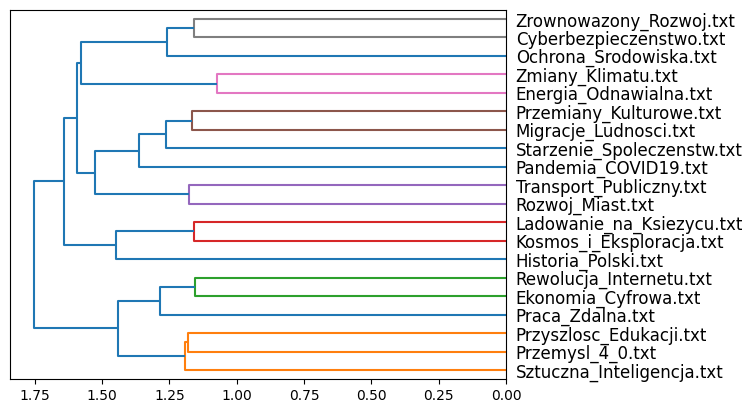

In [54]:
plot_dendrogram(
    clusering,
    labels = file_names,
    truncate_mode = 'level',
    orientation = 'left'
)
plt.show()

In [55]:
n_docs = len(file_names)
ed = euclidean_distances(counts_tf, counts_tf).flatten().reshape(n_docs, n_docs)
ed

array([[ 0.        ,  8.60232527, 10.29563014, 11.95826074,  9.05538514,
        14.        ,  8.71779789,  8.60232527,  9.69535971,  9.2736185 ,
         8.83176087,  8.88819442,  9.2736185 , 11.44552314,  9.16515139,
         8.83176087, 12.32882801,  8.66025404, 12.32882801,  7.87400787],
       [ 8.60232527,  0.        , 10.        , 12.04159458,  8.94427191,
        14.07124728,  8.48528137,  8.94427191,  9.38083152,  9.05538514,
         8.60232527,  8.18535277,  8.60232527, 10.53565375,  9.16515139,
         8.71779789, 12.        ,  9.        , 12.32882801,  8.83176087],
       [10.29563014, 10.        ,  0.        , 12.84523258, 10.        ,
        14.83239697, 10.        , 10.        , 10.39230485, 10.19803903,
         9.69535971, 10.04987562, 10.09950494, 12.68857754, 10.19803903,
        10.29563014, 12.88409873,  9.53939201, 11.74734012,  9.2736185 ],
       [11.95826074, 12.04159458, 12.84523258,  0.        , 11.78982612,
        15.90597372, 11.87434209, 12.04159458, 1

In [56]:
clusering = AgglomerativeClustering(
    n_clusters = 3,
    metric = "precomputed",
    linkage = "complete",
    compute_distances = True
).fit(ed)
clusering.labels_

array([0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

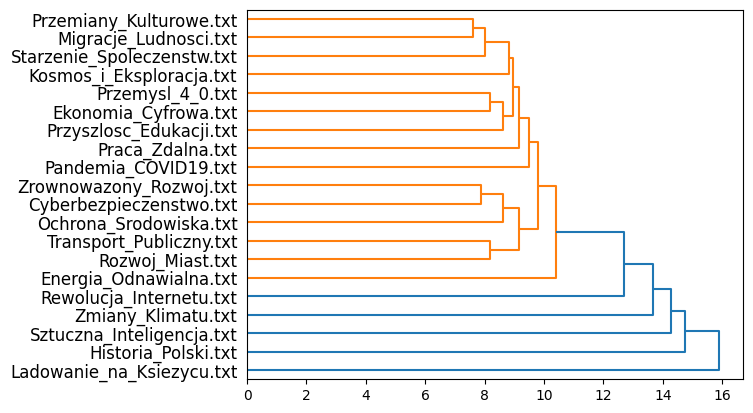

In [57]:
plot_dendrogram(
    clusering,
    labels = file_names,
    truncate_mode = 'level',
    orientation = 'right'
)
plt.show()

# N-gramy

In [58]:
documents_tokenized = {}
for key in documents:
    documents_tokenized[key] = word_tokenize(documents[key], language = 'polish')
print(json.dumps(documents_tokenized, indent = 4, ensure_ascii = False))  

{
    "Cyberbezpieczenstwo.txt": [
        "cyberbezpieczeństwo",
        "to",
        "ochrona",
        "system",
        "komputerowy",
        "sieć",
        "przed",
        "atak",
        "kradzież",
        "dana",
        "zagrożenie",
        "wraz",
        "z",
        "rozwój",
        "technologia",
        "rośnie",
        "liczba",
        "cyberatak",
        "na",
        "firma",
        "osoba",
        "prywatny",
        "skuteczny",
        "ochrona",
        "wymagać",
        "stosować",
        "nowoczesny",
        "narzędzie",
        "edukacja",
        "użytkownik",
        "ciągły",
        "monitorować",
        "zagrożenie",
        "cyberbezpieczeństwo",
        "kluczowy",
        "funkcjonowanie",
        "państwo",
        "firma",
        "instytucja"
    ],
    "Ekonomia_Cyfrowa.txt": [
        "ekonomia",
        "cyfrowy",
        "opierać",
        "się",
        "na",
        "wykorzystanie",
        "technologia",
        "informatyczny",


Cyberbezpieczenstwo.txt


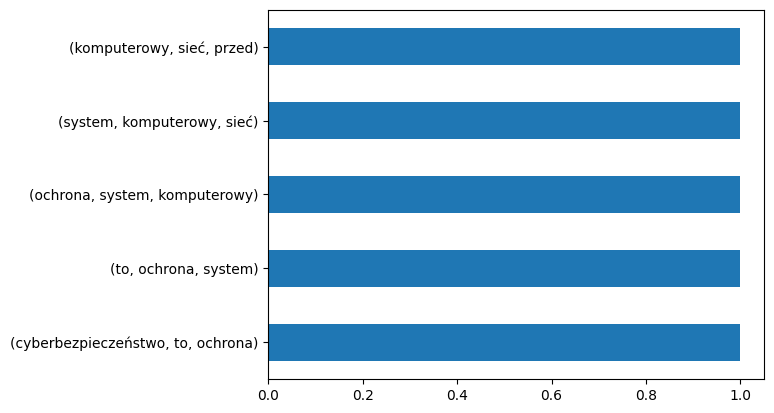

Ekonomia_Cyfrowa.txt


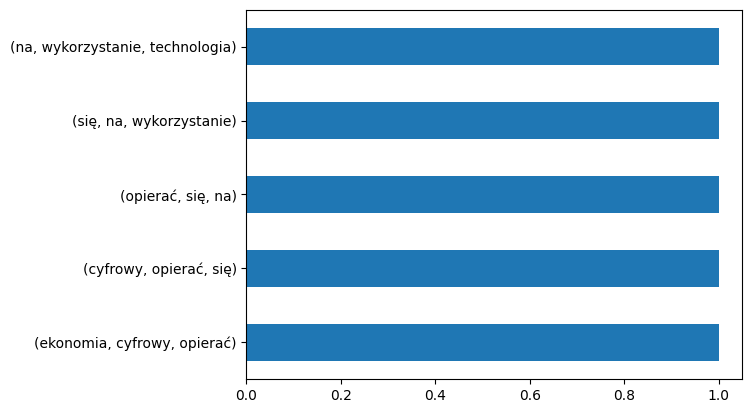

Energia_Odnawialna.txt


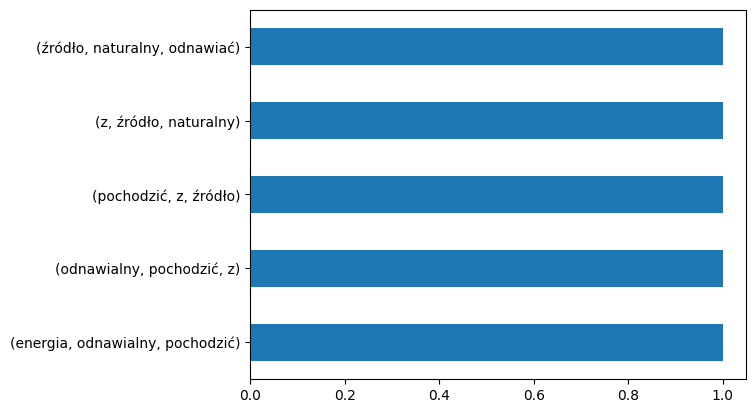

Historia_Polski.txt


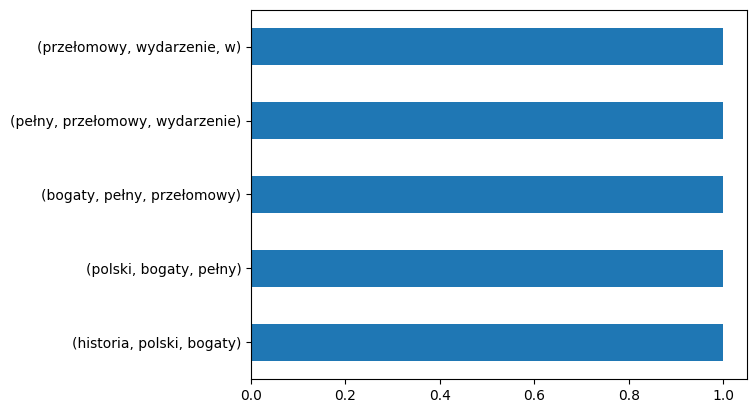

Kosmos_i_Eksploracja.txt


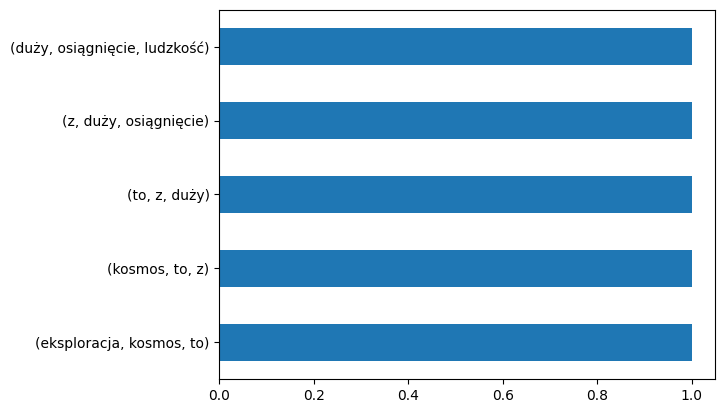

Ladowanie_na_Ksiezycu.txt


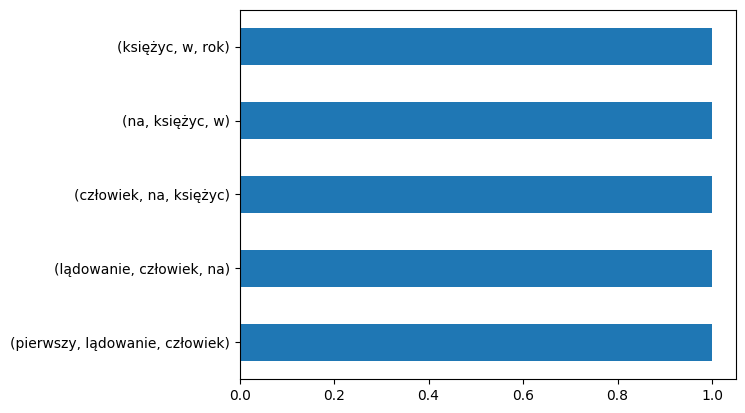

Migracje_Ludnosci.txt


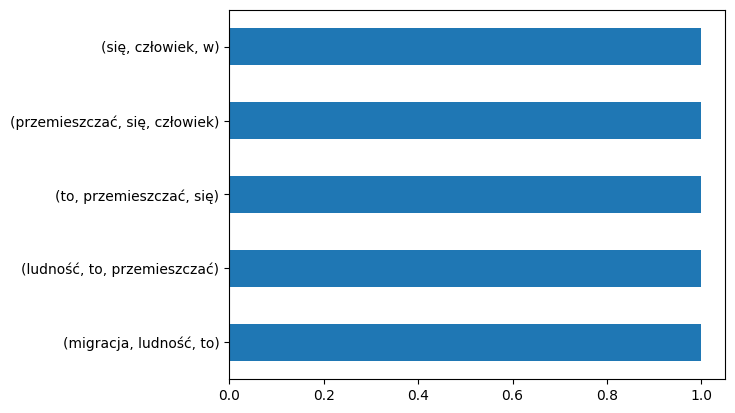

Ochrona_Srodowiska.txt


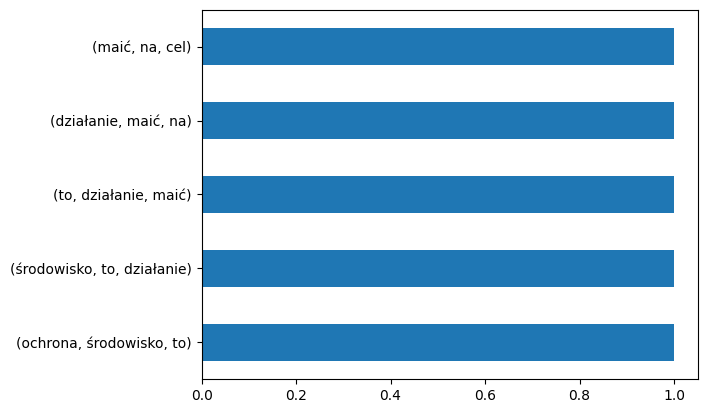

Pandemia_COVID19.txt


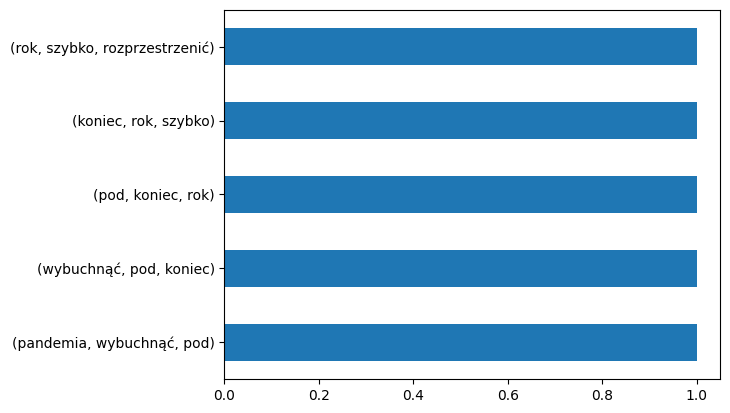

Praca_Zdalna.txt


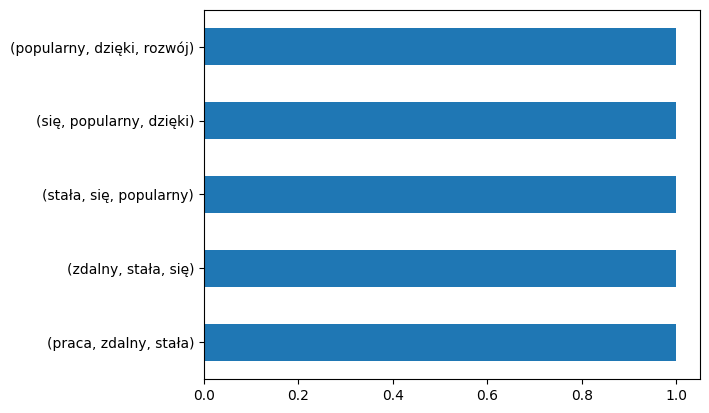

Przemiany_Kulturowe.txt


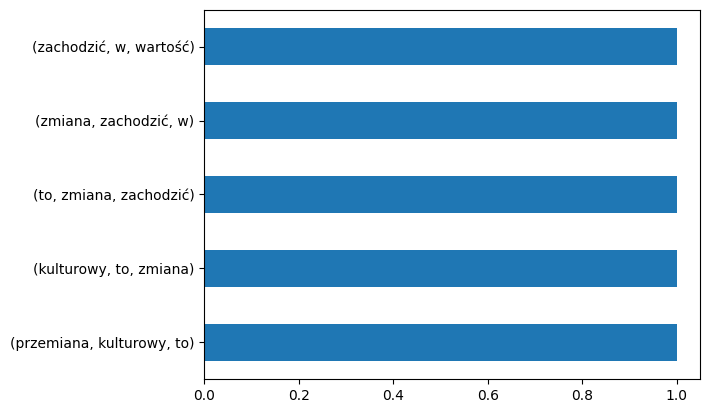

Przemysl_4_0.txt


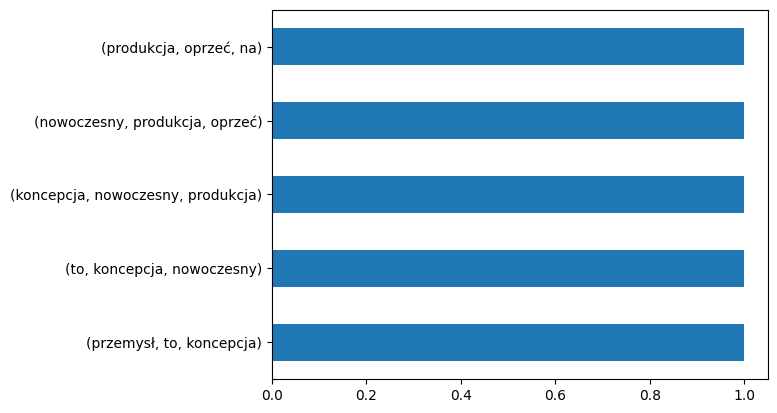

Przyszlosc_Edukacji.txt


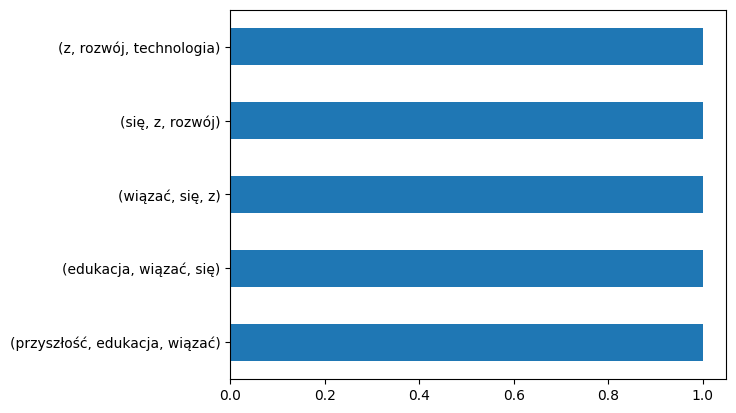

Rewolucja_Internetu.txt


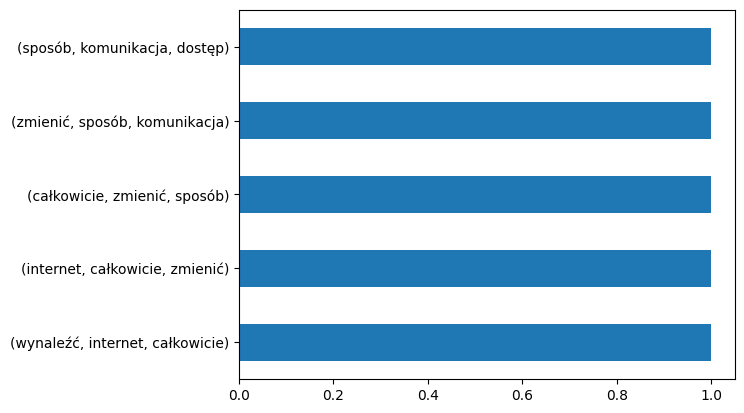

Rozwoj_Miast.txt


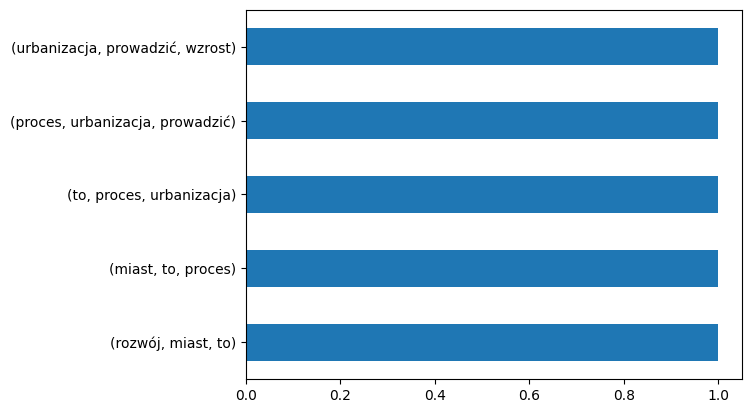

Starzenie_Spoleczenstw.txt


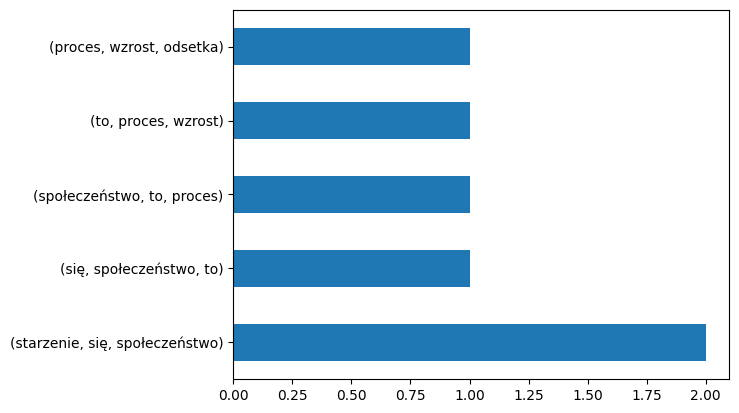

Sztuczna_Inteligencja.txt


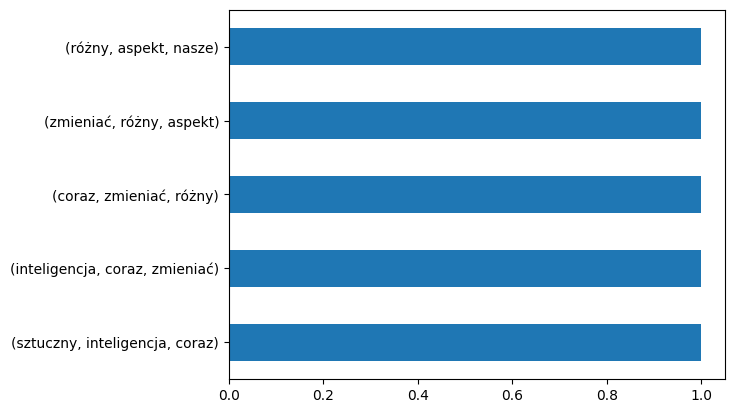

Transport_Publiczny.txt


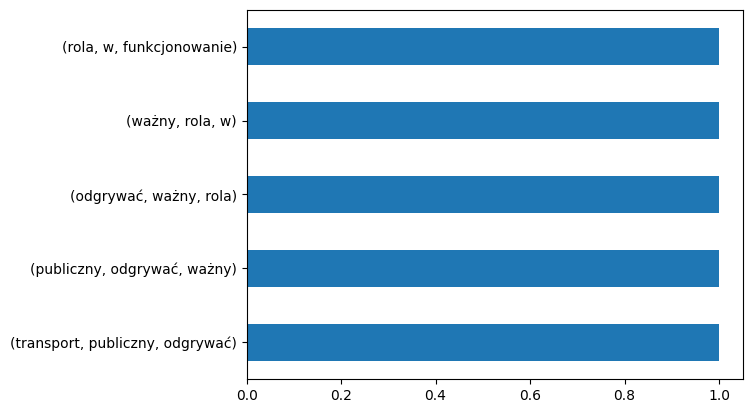

Zmiany_Klimatu.txt


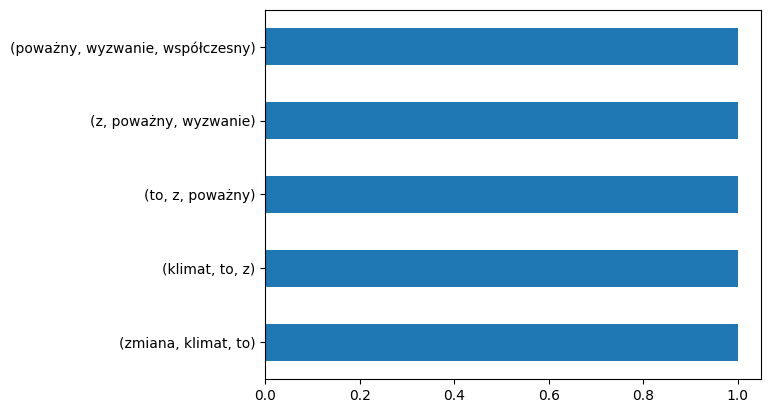

Zrownowazony_Rozwoj.txt


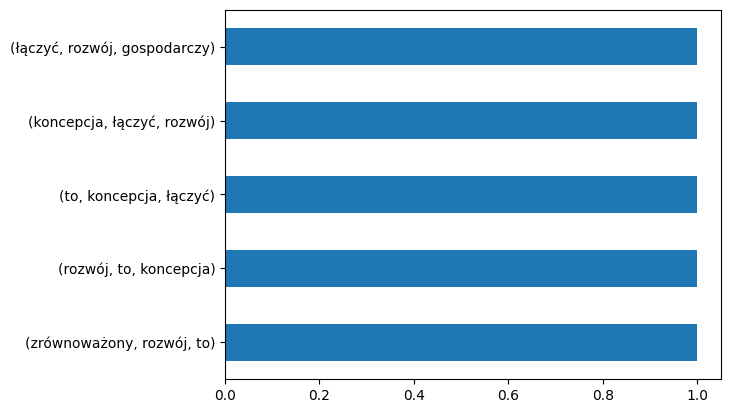

In [59]:
for title in documents_tokenized:
    n_gram = pd.Series(ngrams(documents_tokenized[title], 3)).value_counts()
    print(title)
    n_gram[:5].plot.barh()
    plt.show()

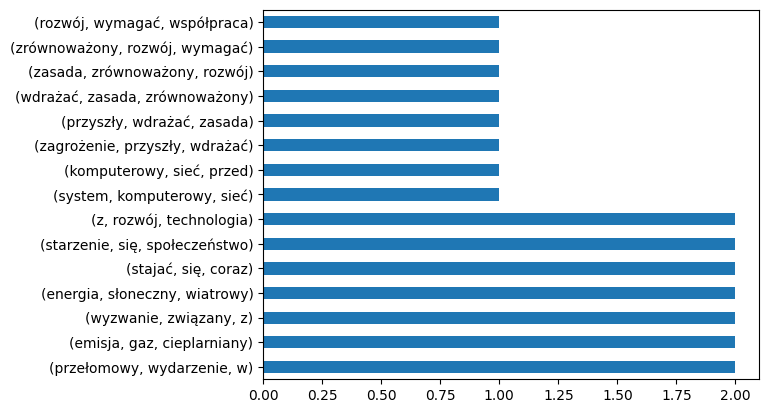

In [60]:
texts = ' '.join(docs['content']).split(" ")
n_gram = pd.Series(ngrams(texts, 3)).value_counts()
n_gram[:15].plot.barh()
plt.show()

# Opis wyników analiz i wnioski

W przeprowadzonej analizie tekstów z własnego zbioru (20 dokumentów) zastosowano modelowanie tematów (topic modelling) z wykorzystaniem trzech tematów (LDA oraz NMF). Wyniki przedstawione na wykresach pokazują, że:

- **Każdy z trzech tematów** odpowiada wyraźnie innym grupom zagadnień obecnych w dokumentach, np. tematy związane z ekologią, technologią czy społeczeństwem.
- **Większość dokumentów** została przypisana głównie do jednego tematu, co świadczy o spójności tematycznej tekstów i skuteczności modelu.
- **Wizualizacje udziału tematów** w poszczególnych dokumentach pozwalają łatwo zidentyfikować, które teksty są najbardziej reprezentatywne dla danego tematu.
- **Analiza skupień** (dendrogramy) potwierdziła, że dokumenty o podobnej tematyce grupują się razem, co dodatkowo potwierdza poprawność wyodrębnionych tematów.
- **Analiza n-gramów** umożliwiła identyfikację najczęściej współwystępujących fraz, co może być pomocne przy dalszej eksploracji zbioru.

**Wnioski:**  
Zastosowane metody pozwoliły skutecznie wydzielić główne tematy w zbiorze tekstów oraz przeanalizować ich rozkład w dokumentach. Takie podejście ułatwia szybkie zrozumienie struktury dużych kolekcji tekstów i może być wykorzystane do dalszych badań lub automatycznej kategoryzacji nowych dokumentów. Modelowanie tematów okazało się przydatnym narzędziem do eksploracji i wizualizacji zawartości własnego zbioru danych.